In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

# Inverse Propensity Score Weighting with `pymc`

In this notebook we will briefly demonstrate how to use propensity score weighting schemes to recover treatment effects in the analysis of observational data. We will first showcase the method with a simulated data example drawn from Lucy D’Agostino McGowan's [excellent blog](https://livefreeordichotomize.com/posts/2019-01-17-understanding-propensity-score-weighting/) on inverse propensity score weighting. Then we shall apply the same techniques to NHEFS data set discussed in Miguel Hernan and Robins' _Causal Inference: What if_ [book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/). This data set measures the effect of quitting smoking between the period of 1971 and 1982. At each of these two points in time the participant's weight was recorded, and we seek to estimate the effect of quitting in the intervening years on the weight recorded in 1982.

We will use inverse propensity score weighting techniques to estimate the average treatment effect. There are a range of weighting techniques available: we have implemented `raw`, `robust`, `doubly robust` and `overlap` weighting schemes all of which aim to estimate the average treatment effect. The idea of a propensity score (very broadly) is to derive a one-number summary of individual's probability of adopting a particular treatment. This score is typically calculated by fitting a predictive logit model on all an individual's observed attributes predicting whether or not the those attributes drive the individual towards the treatment status. In the case of the NHEFS data we want a model to measure the propensity for each individual to quit smoking. 

> ### 🎯 Target Causal Estimands
> 
> Propensity score weighting allows us to estimate different causal effects by changing the "target population" we are interested in. The choice of weight determines which estimand you are calculating:
>
> * **ATE (Average Treatment Effect):** Estimates the effect if the entire population were treated vs. the entire population being untreated. Targeted by the `make_raw_adjustments` and `make_robust_adjustments` methods.
> * **ATO (Average Treatment Effect among the Overlap):** Targeted by `make_overlap_adjustments`. This focuses on units with "clinical equipoise"—those who had a reasonable probability of being in either group. It is highly robust to outliers and eliminates the need for artificial clipping.
> * **Doubly Robust:** The `make_doubly_robust_adjustment` combines a propensity model and an outcome model. It targets the **ATE** but provides "two chances" to be correct: if *either* the propensity model or the outcome model is correctly specified, the estimate remains unbiased.

The reason we want this propensity score is because with observed data we often have a kind of imbalance in our covariate profiles across treatment groups. Meaning our data might be unrepresentative in some crucial aspect. This prevents us cleanly reading off treatment effects by looking at simple group differences. These "imbalances" can be driven by selection effects into the treatment status so that if we want to estimate the average treatment effect in the population as a whole we need to be wary that our sample might not give us generalisable insight into the treatment differences. Using propensity scores as a measure of the prevalance to adopt the treatment status in the population, we can cleverly weight the observed data to privilege observations of "rare" occurrence in each group. For example, if smoking is the treatment status and regular running is generally not common among the group of smokers, then on the occasion we see a smoker marathon runner we should heavily weight their outcome measure to overcome their low prevalence in the treated group but real presence in the unmeasured population. Inverse propensity weighting tries to define weighting schemes are inversely proportional to an individual's propensity score so as to better recover an estimate which mitigates (somewhat) the risk of selection effect bias. For more details and illustration of these themes see the PyMC examples [write up](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_nonparametric_causal.html) on Non-Parametric Bayesian methods. {cite:p}`forde2024nonparam`


## Simulated Data

First we simulate some data for treatment and outcome variables. 

In [2]:
df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=1000),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=1000) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=1000)
)
df1.head()

,x1,x2,trt,outcome
0,-0.114897,-0.201543,0,0.817575
1,0.092183,0.849926,1,3.939113
2,0.174855,0.767423,1,2.590079
3,0.366725,0.028465,0,-0.935481
4,-0.848841,-0.485020,0,-2.132989


Note how we have specified the treatment effect of interest to be exactly 2. 

Now we invoke the `InversePropensityWeighting` experiment class, with the `PropensityScore` model. This will by default fit a simple logistic regression model and store the idata under `result1.idata`. 

In [3]:
seed = 42
result1 = cp.InversePropensityWeighting(
    df1,
    formula="trt ~ 1 + x1 + x2",
    outcome_variable="outcome",
    weighting_scheme="robust",
    model=cp.pymc_models.PropensityScore(
        sample_kwargs={
            "draws": 1000,
            "target_accept": 0.95,
            "random_seed": seed,
            "progressbar": False,
        },
    ),
)

result1

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


We can interrogate this inference data object in the usual fashion to assess the model fit of the propensity score model. Looking here at the parameters in the logistic regression. 

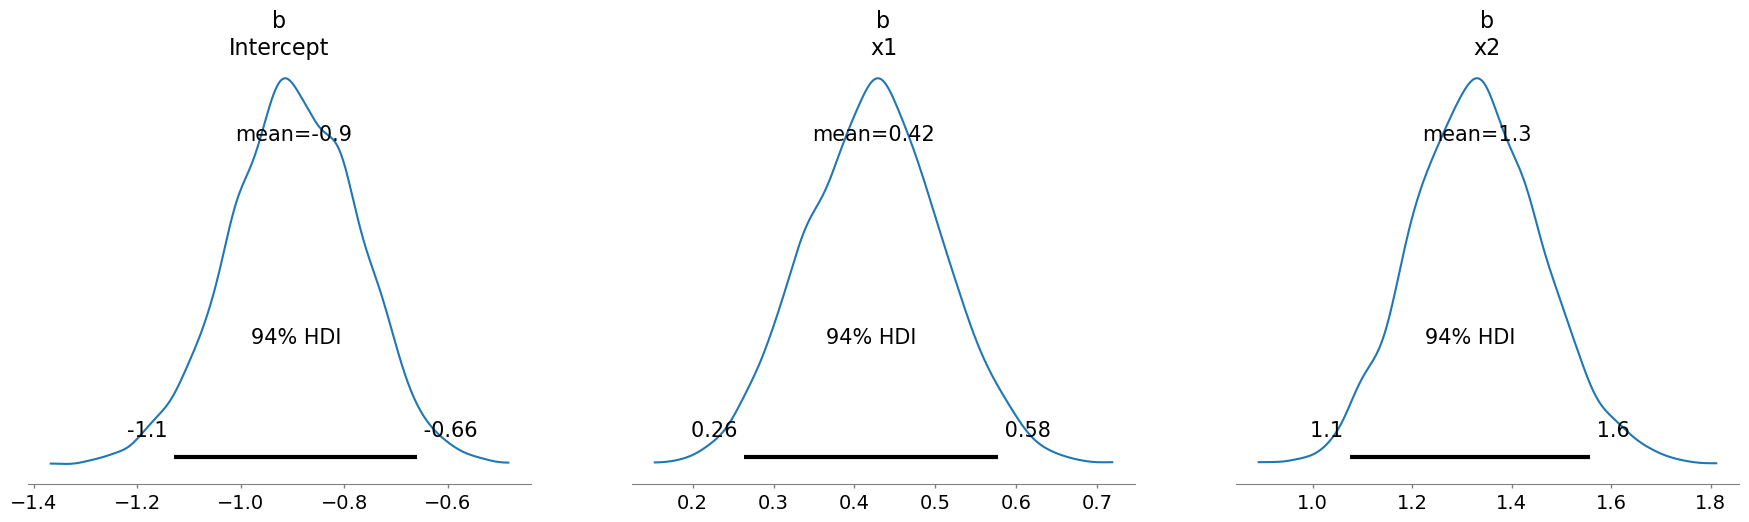

In [4]:
az.plot_posterior(result1.idata, var_names=["b"]);

The health of the sampling trace.

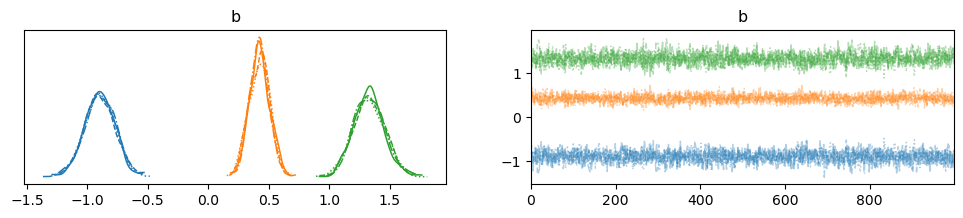

In [5]:
az.plot_trace(result1.idata, var_names=["b"]);

The posterior predictive checks of our propensity model show the predicted binary outcomes (i.e. smoker yes/no) drawn from the posterior predictive distribution in blue. This is contrasted against the observed outcomes in our data set in black. In short this plot shows how the model is able to recover the observed data. 

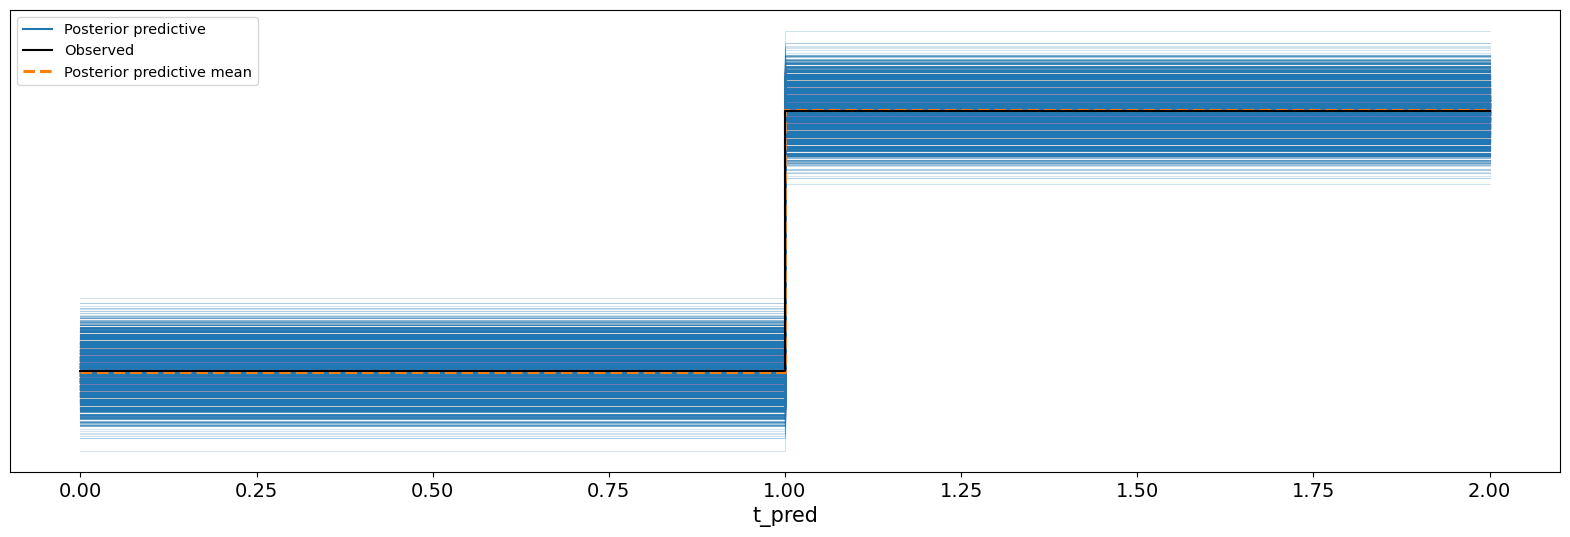

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_ppc(result1.idata, ax=ax);

But our primary focus when we're conducting an inverse propensity weighting experiment is not on the accuracy of the propensity score model itself. Instead we want to incorporate these propensity scores latent in the logistic regression to re-weight the outcomes of interest to have a better, more representative measure of the treatment mitigating some of the risk of selection effects driving the data generating function. 

In [7]:
result1.idata["posterior"]["p"].mean(dim=("chain", "draw"))

<xarray.DataArray 'p' (p_dim_0: 1000)> Size: 8kB
array([0.22991855, 0.56762809, 0.54923547, 0.33154076, 0.13101786,
       0.90565   , 0.73795817, 0.77609189, 0.56130855, 0.61364923,
       0.50652863, 0.68128884, 0.90071257, 0.1055703 , 0.08957225,
       0.73568979, 0.98265493, 0.46197438, 0.97868524, 0.25929722,
       0.63038979, 0.9423198 , 0.35430928, 0.40588564, 0.94236758,
       0.40857988, 0.72051561, 0.77151535, 0.51413804, 0.33222304,
       0.94153894, 0.73991411, 0.67095627, 0.10062896, 0.94284762,
       0.01176359, 0.95819376, 0.51768642, 0.33496164, 0.77463414,
       0.76321686, 0.86993286, 0.76651283, 0.80088843, 0.92380332,
       0.10010528, 0.6180706 , 0.38881804, 0.13059035, 0.94529189,
       0.74429115, 0.92256794, 0.97782645, 0.20391524, 0.57393309,
       0.96694211, 0.9931652 , 0.46069396, 0.75283367, 0.97357262,
       0.88495504, 0.39517195, 0.84822301, 0.03554698, 0.3667997 ,
       0.95015399, 0.86594142, 0.55259219, 0.78031381, 0.03985003,
       0.12513394, 0.58796694, 0.57949715, 0.77840236, 0.84771472,
       0.24688706, 0.24016718, 0.09246299, 0.6235687 , 0.5497323 ,
       0.91552846, 0.71531279, 0.43837431, 0.09634551, 0.5879161 ,
       0.93528626, 0.71895323, 0.8425932 , 0.97140169, 0.99007062,
       0.71271832, 0.91548221, 0.1967476 , 0.16682814, 0.99798739,
       0.56361599, 0.92293051, 0.52495428, 0.56932166, 0.96983517,
...
       0.82768649, 0.19036568, 0.33861   , 0.81344196, 0.59454588,
       0.67588749, 0.81182761, 0.92937087, 0.78630207, 0.20824103,
       0.85810224, 0.58897094, 0.92380045, 0.31762299, 0.9454904 ,
       0.88981141, 0.88917413, 0.89886231, 0.07594186, 0.27131399,
       0.54306009, 0.71869117, 0.52226595, 0.17282803, 0.96379404,
       0.39690694, 0.499242  , 0.47887317, 0.34013806, 0.56956272,
       0.98004588, 0.51438749, 0.18967911, 0.82911349, 0.72564401,
       0.98989723, 0.12904026, 0.55205029, 0.14975999, 0.93390006,
       0.87863181, 0.07855327, 0.89857086, 0.88728086, 0.20419002,
       0.6385863 , 0.91747701, 0.86335736, 0.5750878 , 0.47644852,
       0.50430095, 0.81502135, 0.76896681, 0.65947119, 0.894382  ,
       0.98360034, 0.65626487, 0.42990073, 0.19689896, 0.9234453 ,
       0.97088718, 0.93652311, 0.49075716, 0.97025494, 0.24703079,
       0.35649886, 0.92822604, 0.42877373, 0.32257978, 0.87181566,
       0.90497978, 0.42259476, 0.52786134, 0.10691118, 0.55327843,
       0.68085144, 0.87055035, 0.28679431, 0.43025506, 0.09359449,
       0.59938905, 0.81329538, 0.94282743, 0.6611894 , 0.8536847 ,
       0.80168869, 0.45260188, 0.75798934, 0.48457008, 0.78612254,
       0.88872744, 0.11150467, 0.54875205, 0.8467336 , 0.77483456,
       0.32846017, 0.67977028, 0.48713469, 0.55905263, 0.21988005])
Coordinates:
  * p_dim_0  (p_dim_0) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

It is these propensity scores which we will use to determine how to weigh the contribution of each individual in our sample when calculating the causal contrast of interest. 

## Evaluating Balance

One of the main criteria for success with the estimation of propensity scores is to check how balanced the covariate profiles of our data are across the treatment status under different re-weighting schemes. A good balance of the covariate values across the treatment status is suggestive of the requirement that assignment to a treatment status should be as good as random when conditional on the covariate profile $X$. That is to say, the condition of __strong ignorability__ holds when the treatment status $T$ is independent of the propensity $p(X)$ conditional on $X$.

One visual way to analyse this balance is to look at the empirical cumulative distribution function for each covariate conditional on the different realisation of propensity scores under the different weighting schemes. We can contrast the difference in the shapes of the ECDFs using the following function.

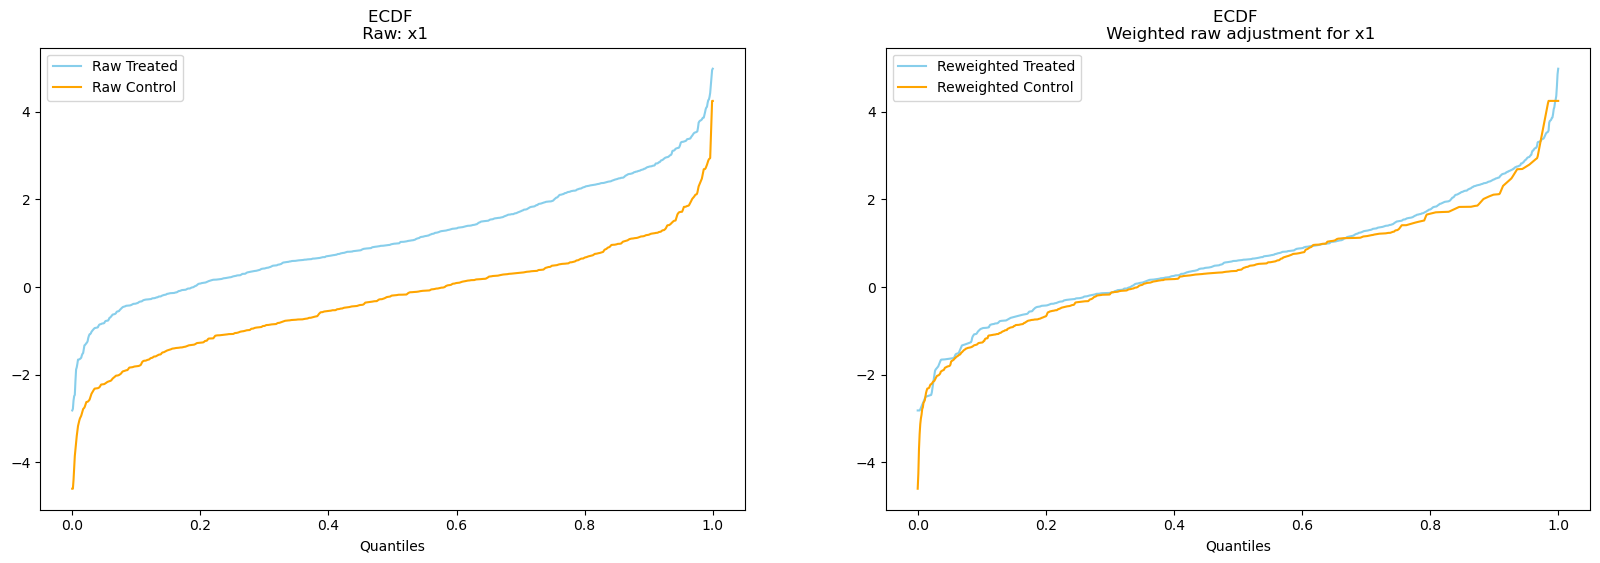

In [8]:
result1.plot_balance_ecdf("x1", weighting_scheme="raw");

On the left we see the unweighted ECDF of the `x1` variable for both treatment and control groups. On the right we show the same but have used weigting to better align the two ECDF profiles. Note here how the re-weighting of the variable using the raw scheme has served to align the shapes of the distribution among both treatment groups, apart from a slight gap at the upper quantiles of the re-weighted ECDF. What happens if we use a different weighting scheme?

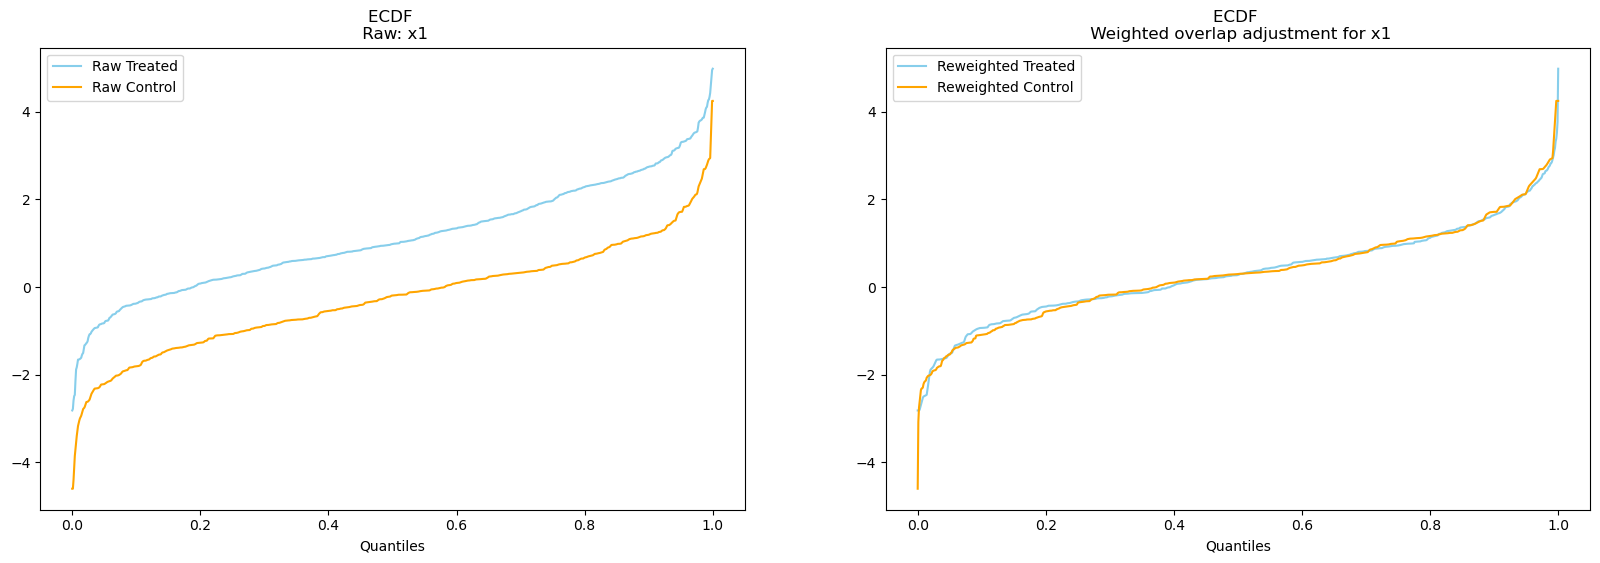

In [9]:
result1.plot_balance_ecdf("x1", weighting_scheme="overlap");

Here we see an even tighter alignment. This weighting scheme refers to the ATO: Average Treatment Effect Among the Overlap Population described in Lucy D’Agostino McGowan's linked [blog](https://livefreeordichotomize.com/posts/2019-01-17-understanding-propensity-score-weighting/). In both cases we can be reasonably happy that conditional on the propensity the weighting mechanism serves to balance the covariate distribution across the treatment effects. 

Reminder - by using these propensity scores we are trying to reduce the bias due to selection effects. When the covariate distributions are balanced or close in these plots conditional on our propensity score weighting, we are arguing that this justifies treating the reweighted causal contrast as akin to one derived in an experiment where the treatment assignment mechanism was __really__ random. We are trying to weight our data to recreate the conditions of as-if-random-allocation to the treatment, and use this to appeal to license our causal conclusion. Next we'll look to estimate the average treatment effect under these schemes and see if we can discern differences in achieved accuracy. 


## Estimating the Average Treatment Effect

Again the `InversePropensityWeighting` class bundles the functionality to inspect the propensity score distribution and evaluate the average treatment effect under different weighting schemes

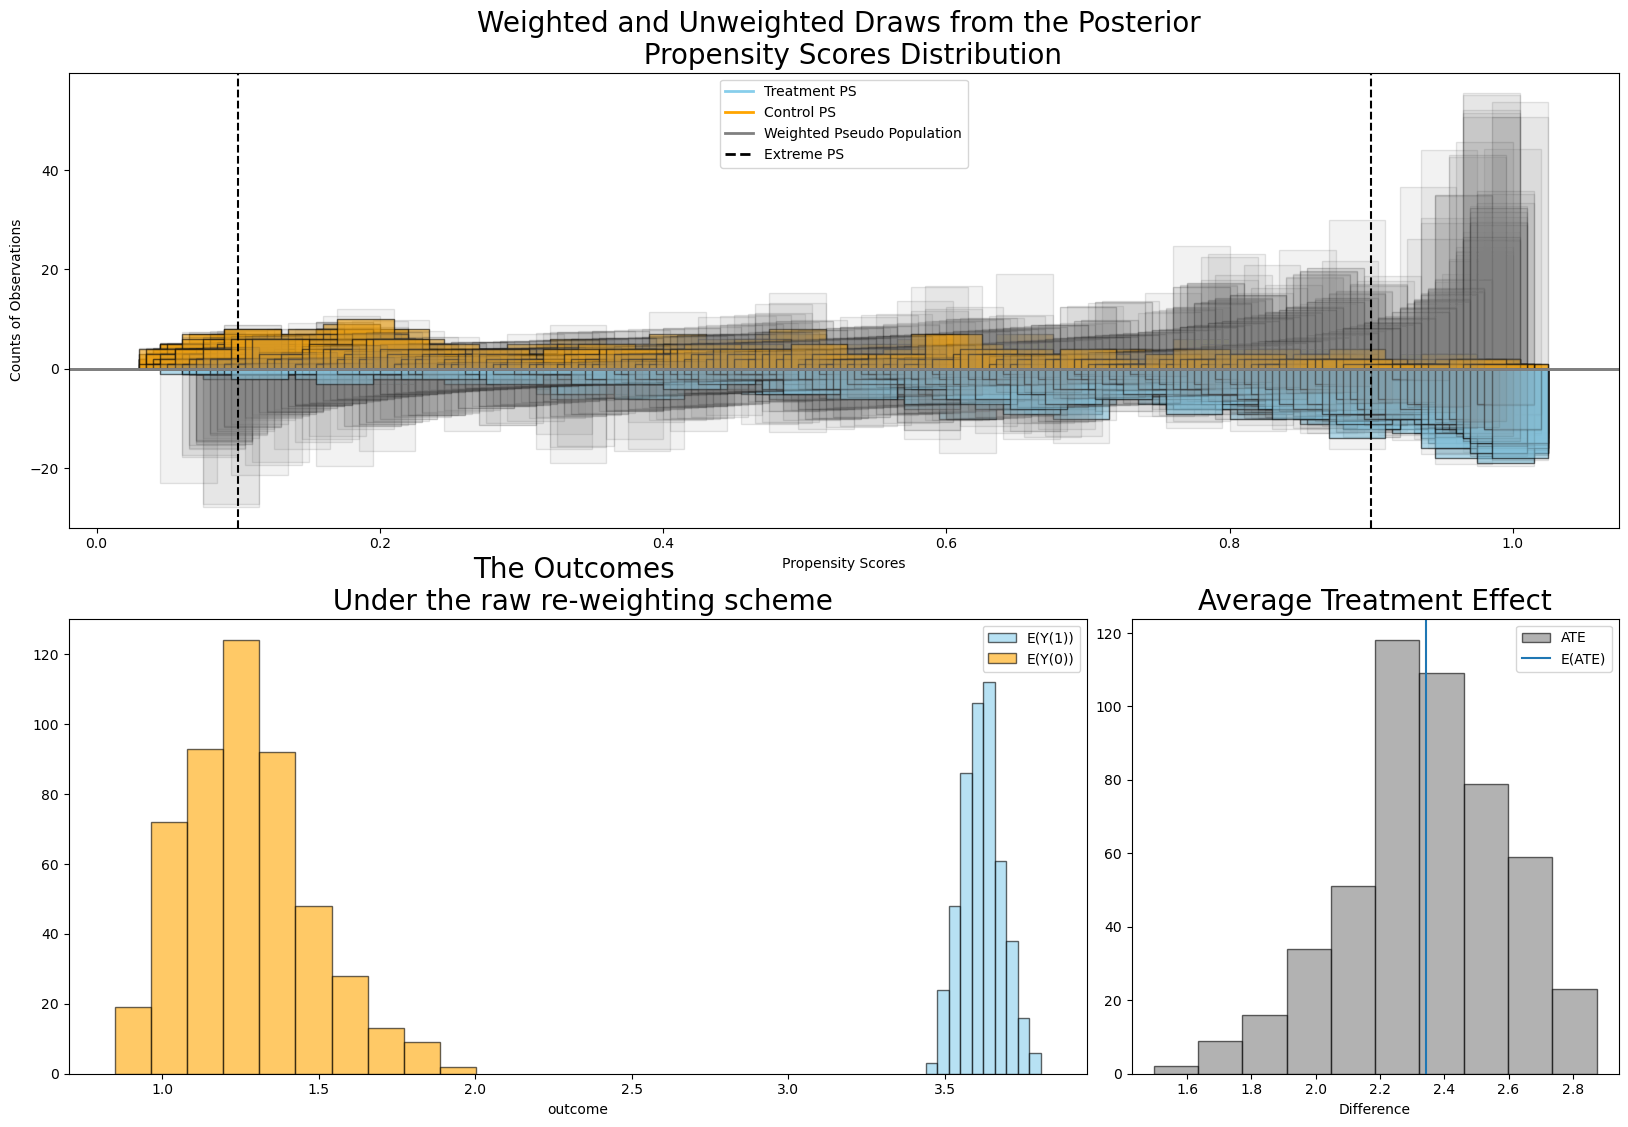

In [10]:
result1.plot_ate(method="raw", prop_draws=10, ate_draws=500);

Here we have plotted in three panels: 

- mirrored draws from the propensity score distribution split by treated and control groups in the yellow and blue with the grey showing the pseudo-population created by the weighting. 
- the expected outcome in those groups under re-weighting under each draw.
- the derived estimates for the average treatment effect. 
    
Note here how expected value of the ATE is pulled slightly away from the true value under this weighting scheme. This is likely due to the high number of individuals with extreme propensity scores - denoted here in the first plot as individuals with propensity scores in excess of .9 and below .1.

Let's check what happens using the overlap weighting scheme?

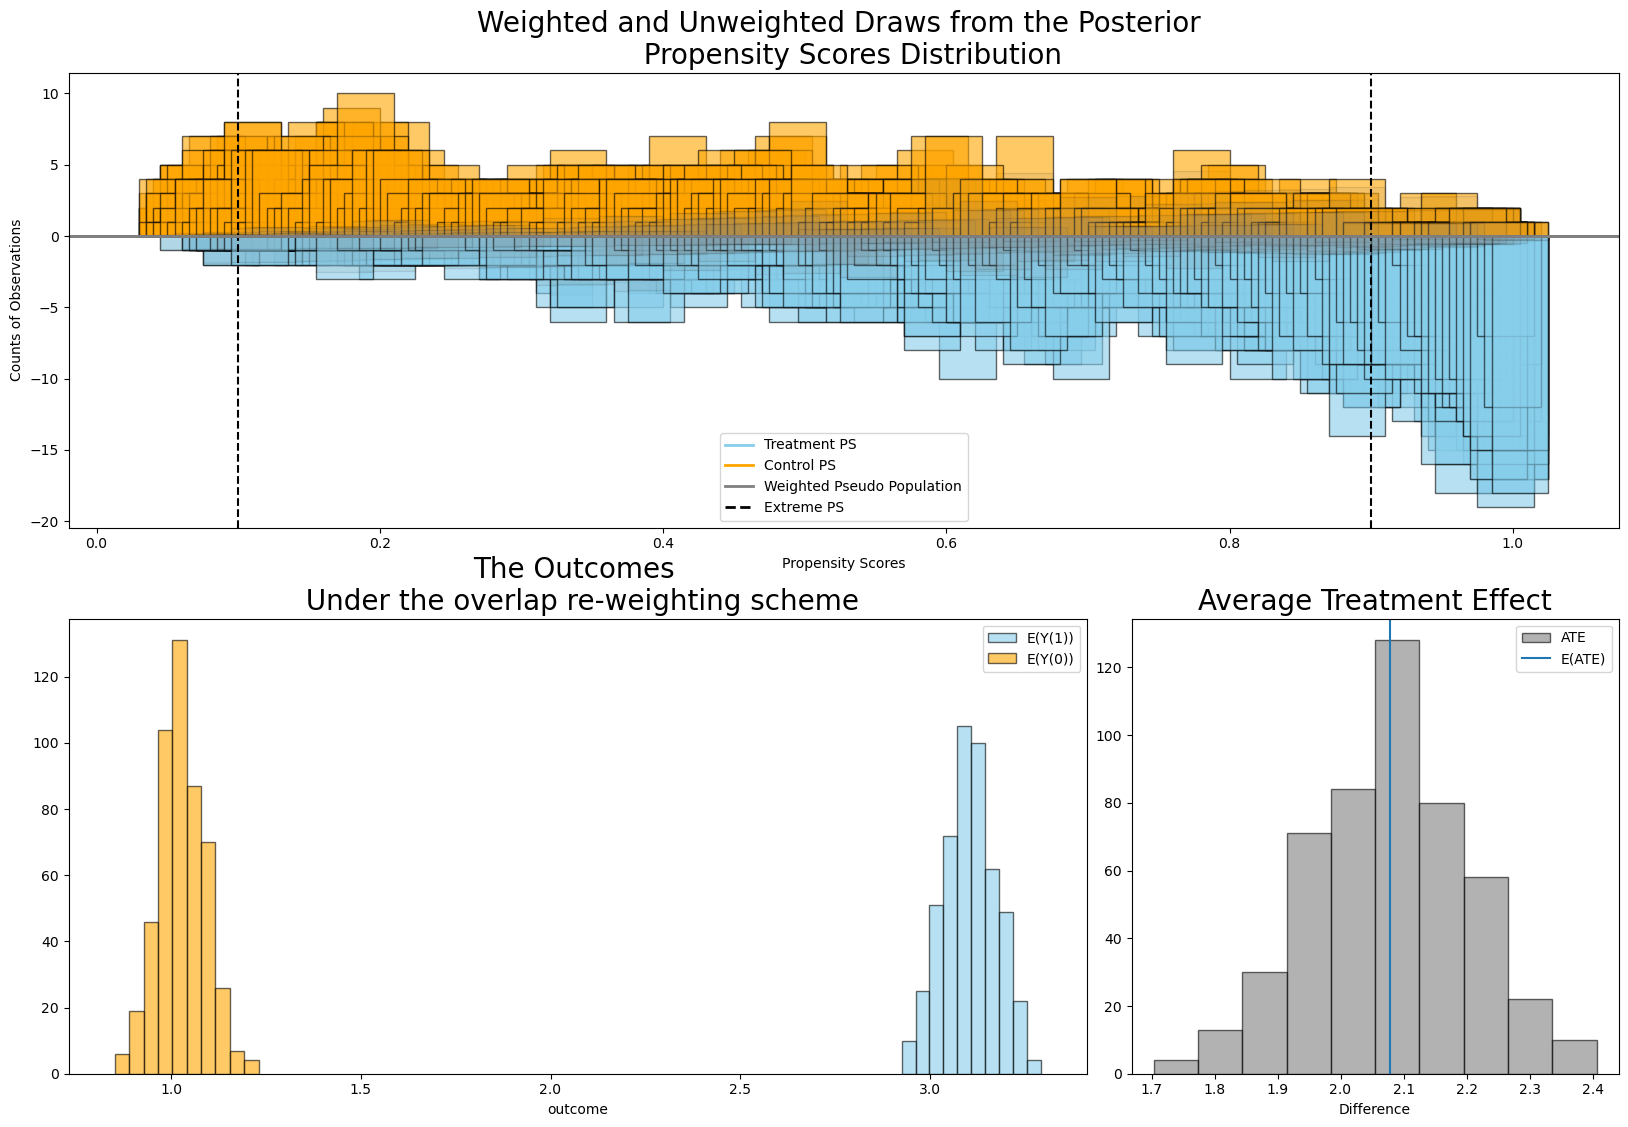

In [11]:
result1.plot_ate(method="overlap", prop_draws=10, ate_draws=500);

We see here how the particular weighting scheme was able to recover the true treatment effect by defining a contrast in a different pseudo population. This is a useful reminder in that, while propensity score weighting methods are aids to inference in observational data, not all weighting schemes are created equal and we need to be careful in our assessment of when each is applied appropriately. Fundamentally the weighting scheme of choice should be tied to the question of what are you trying to estimate. Aronow and Miller's _Foundations of Agnostic Statistics_ {cite:p}`aronowFoundations` has a good explanation of the differences between the `raw`, `robust` and `doubly robust` weighting schemes. In some sense these offer an escalating series of refined estimators each trying to improve the variance in the ATE estimate. The `doubly robust` approach also tries to offer some guarantees against model misspecification. The `overlap` estimator represents an attempt to calculate the ATE among the population with the overlapping propensity scores. This can be used to guard against poor inference in cases where propensity score distributions have large non-overlapping regions.

--------------------------


## NHEFS Data

Now we'll apply the same techniques to real data. 

This data set from the National Health and Nutrition Examination survey records details of weight, activity and smoking habits of around 1500 individuals over two periods. The first period established a baseline and a follow-up period 10 years later. We will analyse whether the individual (`trt == 1`) quit smoking before the follow up visit. Each individuals’ outcome represents a relative weight gain/loss comparing the two periods.

In [12]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()
df_standardised = df.copy()
df_standardised = (df_standardised - df_standardised.mean()) / df_standardised.std()
df_standardised["trt"] = df["trt"]
df_standardised["outcome"] = df["outcome"]
df_standardised.head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,trt,outcome
0,-0.138421,2.568604,-1.026861,0.804858,0.367393,0.536019,-0.916325,-0.324168,-0.526448,-0.827796,-0.289281,-0.356859,-0.854354,1.259927,-0.261669,0.417487,0.548975,0.139278,0,-10.093960
1,-0.638846,-0.389068,-1.026861,-0.044645,-0.048975,-0.796670,-0.916325,-0.324168,1.898310,-0.827796,-0.289281,-0.356859,-0.854354,-0.793190,-0.690113,-0.760410,-0.257819,-0.260558,0,2.604970
2,1.029237,2.568604,0.973219,-0.044645,0.117572,-0.915508,-0.916325,-0.324168,1.898310,-0.827796,-0.289281,-0.356859,-0.854354,1.259927,0.994366,-0.848485,-0.257819,-0.109676,0,9.414486
3,2.030086,2.568604,-1.026861,-1.488800,2.365960,-0.745086,1.090619,-0.324168,-0.526448,-0.827796,-0.289281,-0.356859,-0.854354,1.259927,2.356596,-0.721315,-0.888732,3.108629,0,4.990117
4,-0.305229,-0.389068,-1.026861,-0.044645,-0.465343,1.061651,1.090619,-0.324168,1.898310,-0.827796,-0.289281,-0.356859,1.169728,-0.793190,-0.411808,0.978108,-0.257819,-0.584953,0,4.989251


In [13]:
formula = """trt ~ 1 + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2"""

result = cp.InversePropensityWeighting(
    df_standardised,
    formula=formula,
    outcome_variable="outcome",
    weighting_scheme="robust",  ## Will be used by plots after estimation if no other scheme is specified.
    model=cp.pymc_models.PropensityScore(
        sample_kwargs={
            "draws": 1000,
            "target_accept": 0.95,
            "random_seed": seed,
            "progressbar": False,
        },
    ),
)

result

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


### Evaluating Balance

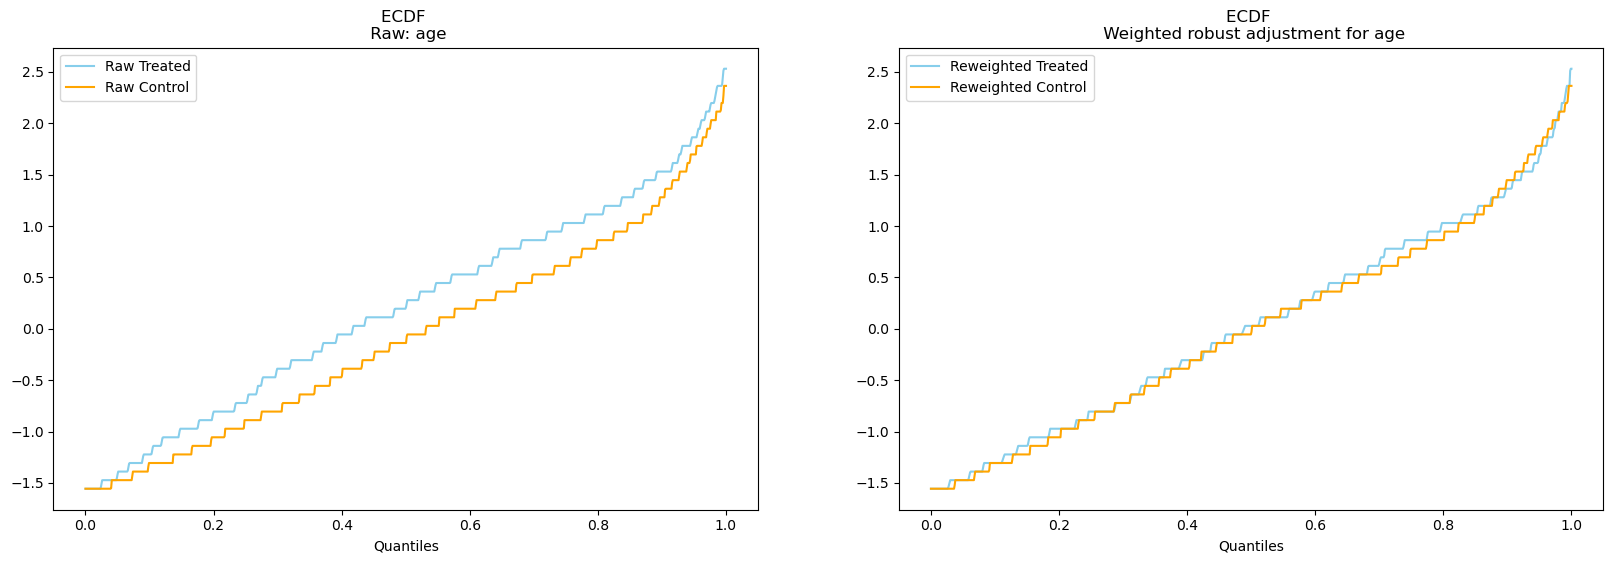

In [14]:
result.plot_balance_ecdf("age");

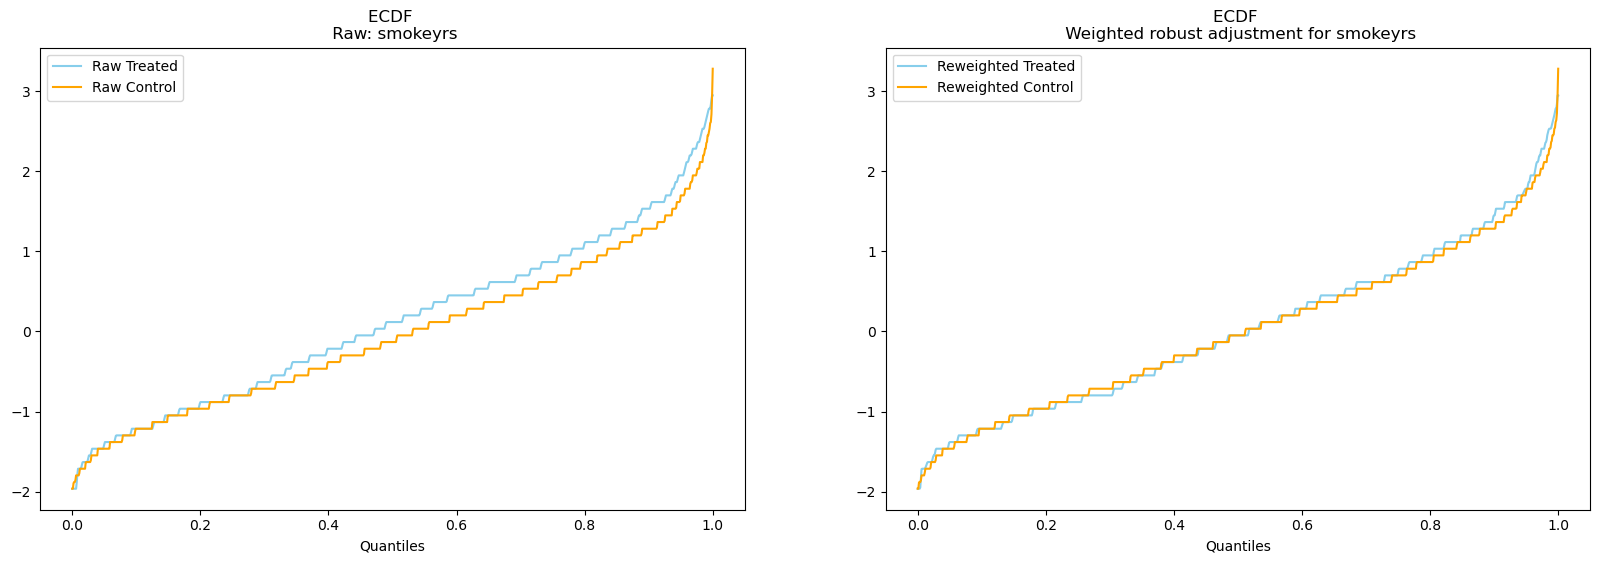

In [15]:
result.plot_balance_ecdf("smokeyrs");

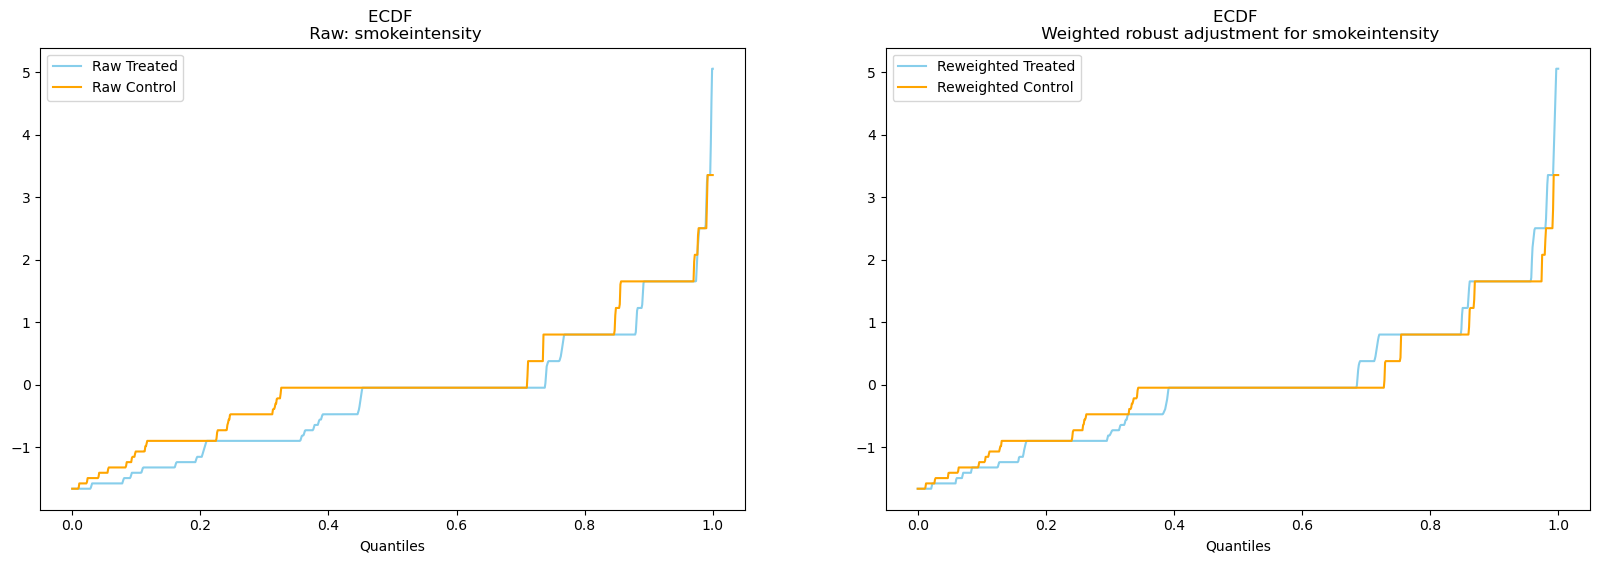

In [16]:
result.plot_balance_ecdf("smokeintensity");

In all cases re-weighting seems to have a positive effect and helps achieve conditional balance.

### Estimating the Average Treatment Effect

Here we'll use two different weighting schemes to highlight the functionality of the `robust` and `doubly robust` weighting. We can use these two approaches by passing in different kwargs to the plotting functions. We are still re-weighting the same propensity score distribution derived with our logit model above.   

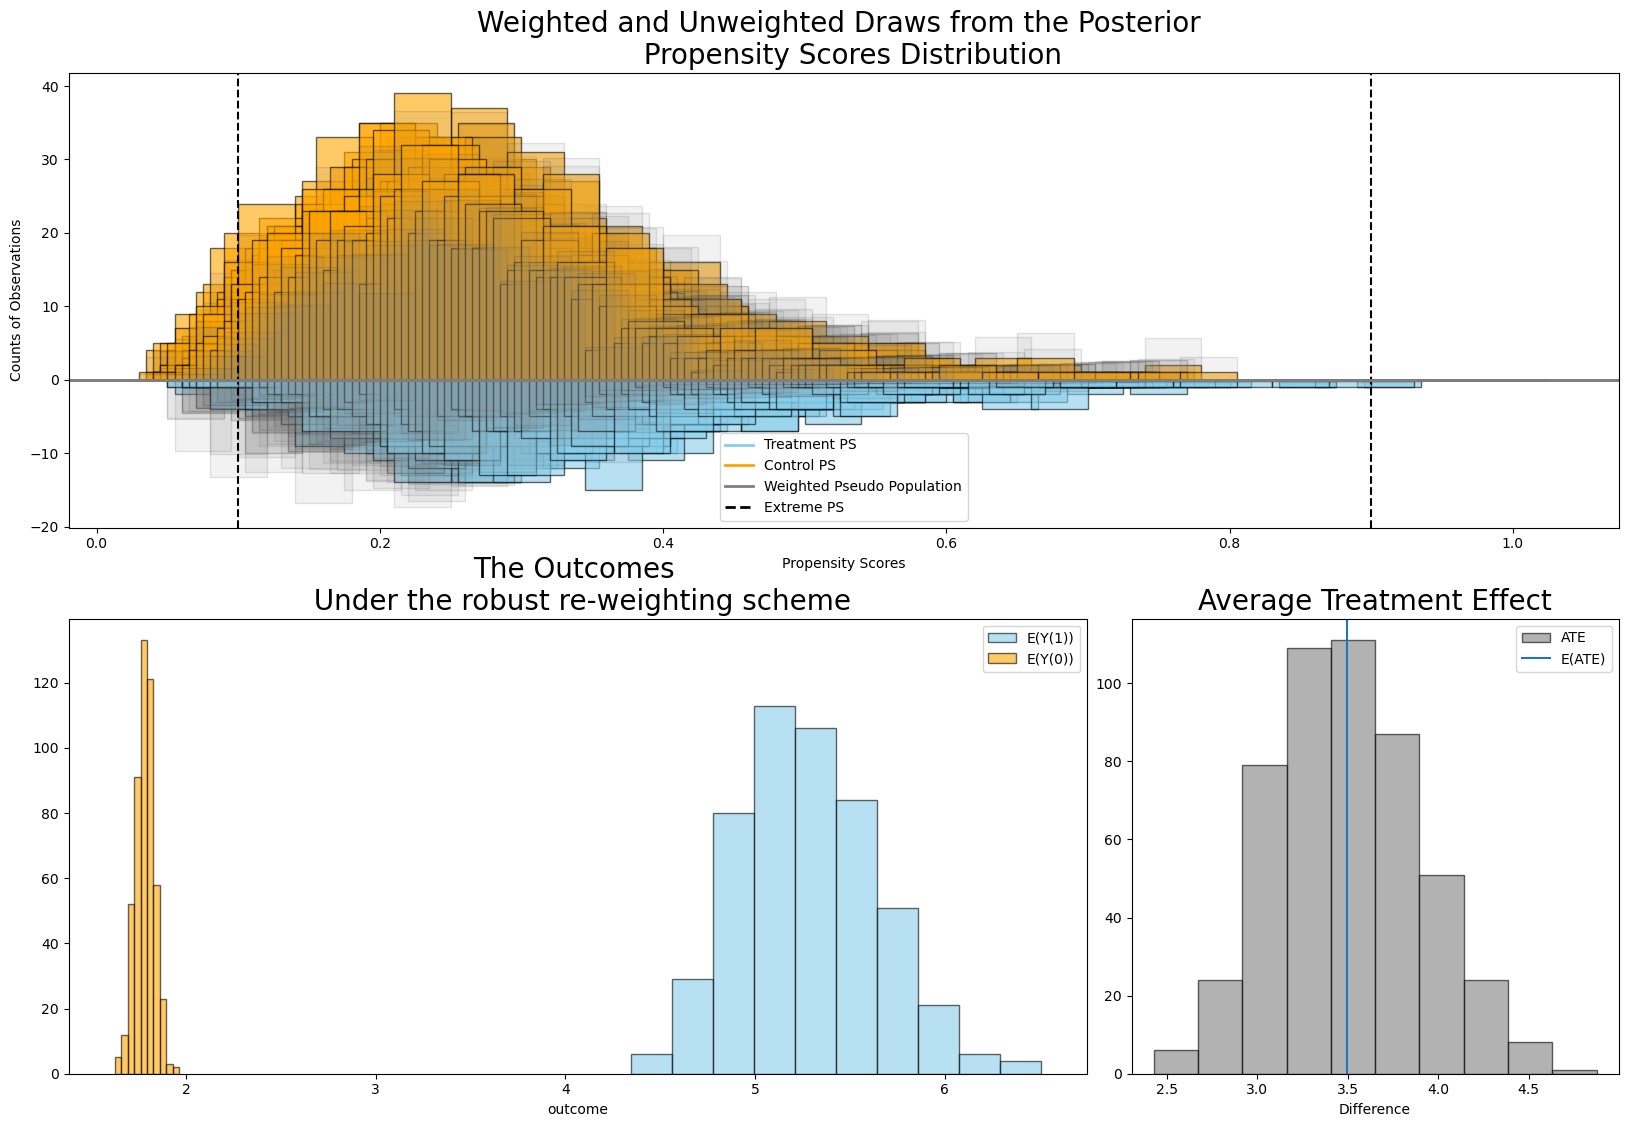

In [17]:
result.plot_ate(method="robust", prop_draws=10, ate_draws=500);

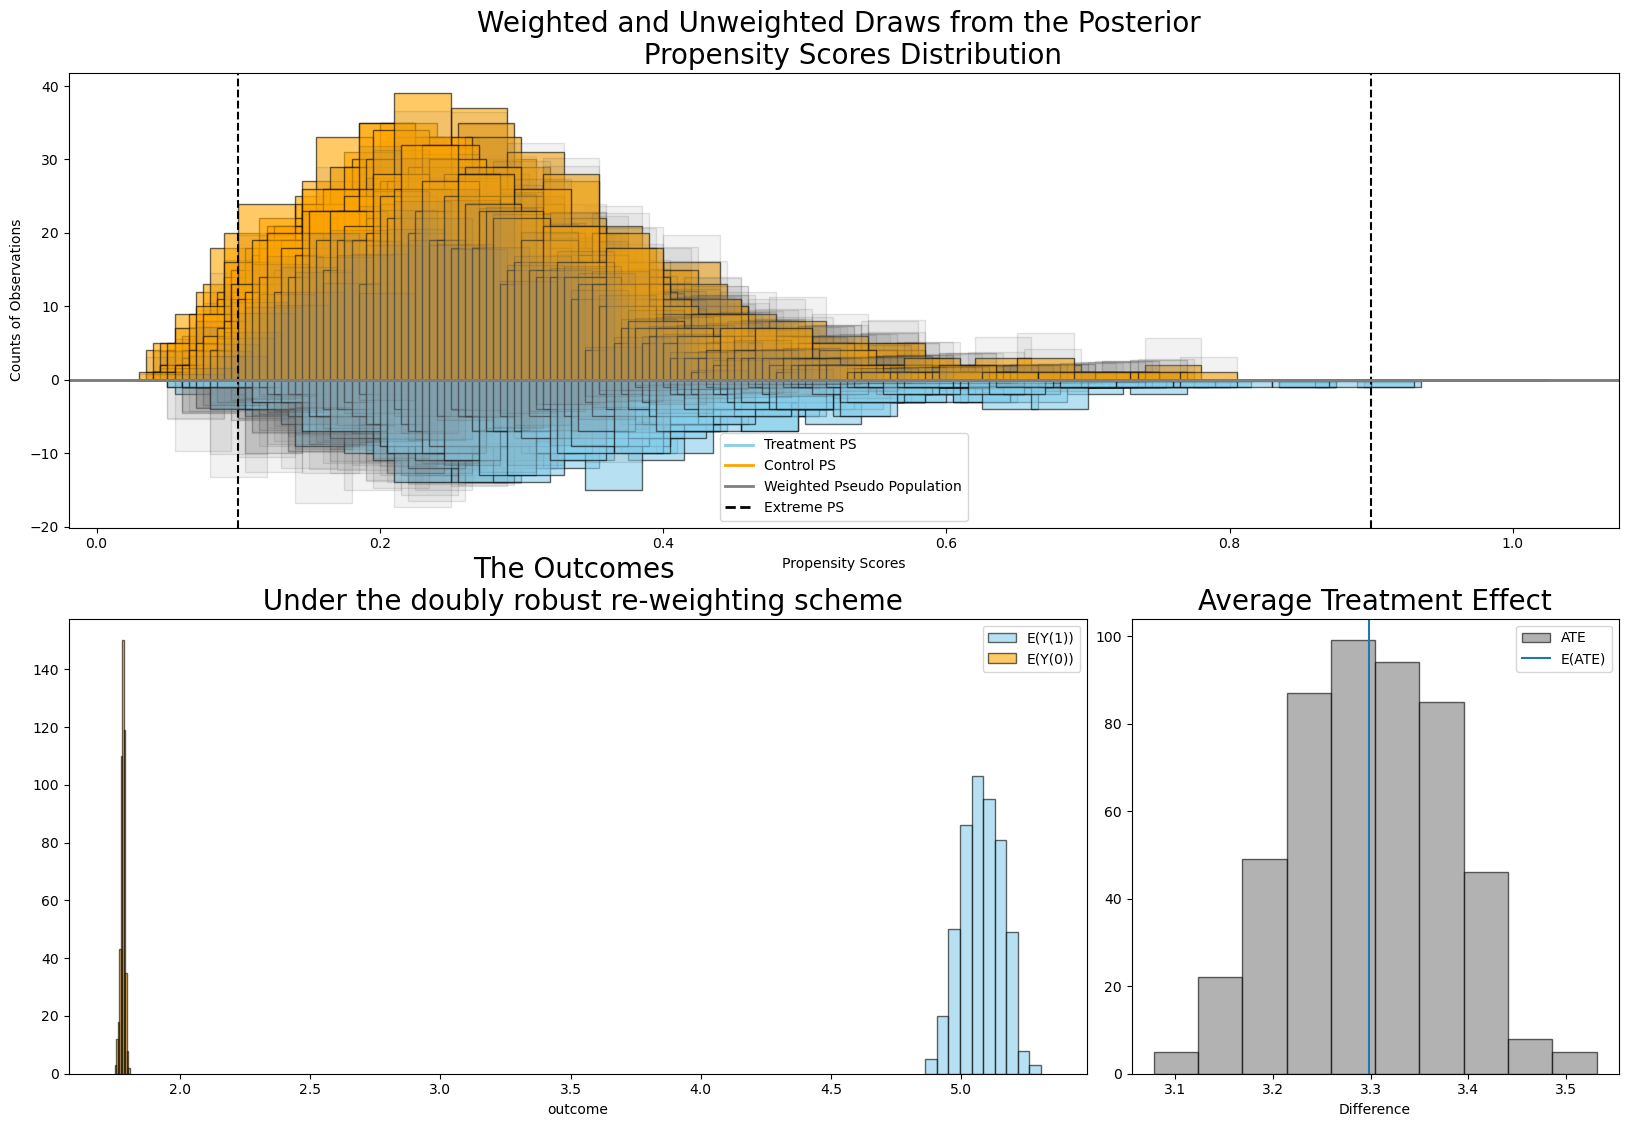

In [18]:
result.plot_ate(method="doubly robust", prop_draws=10, ate_draws=500);

The thing to note here is that while (a) the propensity distributions for both control and treatment groups seem broadly overlapping and (b) both weighting schemes recover substantially similar effects here, the variance on the doubly robust estimator is much tighter. This aspect of the doubly robust estimator is by design and can be important where precise estimation of the treatment effects are important. It will not always be true that the `robust` and `doubly robust` weighting schemes will yield similar results, and as such differences between these methods could point to issues with the propensity score model. 


__Note__:  
We have limited our focus on the implementation of the inverse propensity score weighting for CausalPy to a simple Logistic regression model of the propensity score. However, the analysis routines of the `InversePropensityWeighting` experiment class will run on any arviz inference data object where the propensity score posterior distribution can be identified as `p`. So this frees up the possibility of using non-parametric propensity score designs as discussed in more depth [here](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_nonparametric_causal.html). {cite:p}`forde2024nonparam`

## Conclusion

This concludes our brief tour of inverse-propensity weighting experiments. Propensity modelling and propensity weighting are a powerful tool in causal inference and their potential is by no means limited to the use-cases implemented here. Thinking through the propensity score mechanism and what drives different selection effects is always a good first step in causal modelling. If the drivers of treatment choice can be modelled well propensity score adjustment is often a good way to recover the causal quantity of interest. 

## References
:::{bibliography}
:filter: docname in docnames
:::